# SOD314 Project

## Part I

In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

In [12]:
with open('first_database.pkl', 'rb') as f:
    x,y = pickle.load(f)

In [13]:
# Print the number of points in x and y
print("Number of points in x:", len(x))
print("Number of points in y:", len(y))

Number of points in x: 1000000
Number of points in y: 1000000


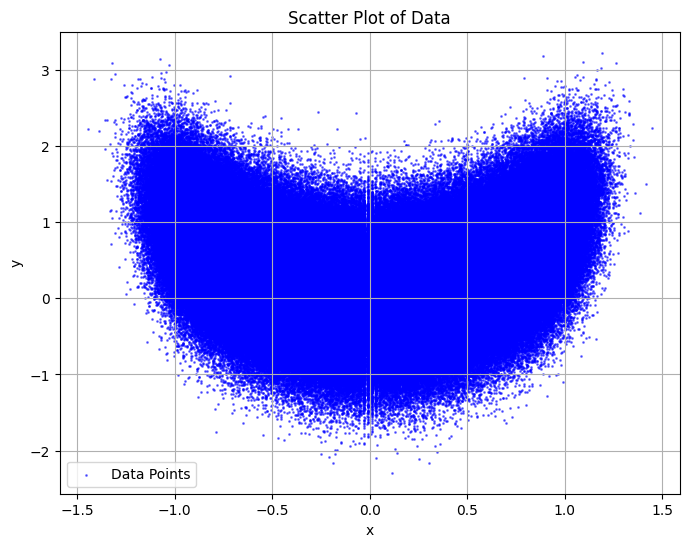

In [14]:
# Create a scatter plot to visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue',s=1, alpha=0.5, label='Data Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')
plt.legend()
plt.grid(True)
plt.show()

## Decentralized gradient descent

In [15]:
n=100 # number of data points used for approximation
m=10 # approximation with m=sqrt(n)
a=5 #number of agents

In [16]:
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])
y_selected = np.array([y[i] for i in ind])

In [17]:
def euclidean_kernel(x, xi, k=1):
    return np.exp(-k * np.linalg.norm(x - xi)**2)

def compute_kernel_matrix(X, Y, k):
    n = X.shape[0]
    m = Y.shape[0]
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            K[i, j] = euclidean_kernel(X[i], Y[j], k)
    return K

def compute_alpha_star(Kmm, Knm, y, sigma_squared, nu):
    n = Knm.shape[0]
    m = Kmm.shape[0]
    A = sigma_squared * Kmm + np.dot(Knm.T, Knm) + nu * np.eye(m)
    b = np.dot(Knm.T, y)
    alpha_star = np.linalg.solve(A, b)
    return alpha_star

In [18]:
# Compute kernel matrices
Kmm = compute_kernel_matrix(x, x, k=0.5)
Knm = compute_kernel_matrix(x, x, k=0.5)

# Stack the target vector
y_stacked = y.reshape(-1, 1)

# Define parameters
sigma_squared = 0.5  # Example value
nu = 1.0  # Regularization parameter

# Compute optimal alpha vector
alpha_star = compute_alpha_star(Kmm, Knm, y_stacked, sigma_squared, nu)

# Plot the result
x_pred = np.linspace(min(x), max(x), 1000).reshape(-1, 1)
K_pred = compute_kernel_matrix(x_pred, x, k=0.5)
y_pred = np.dot(K_pred, alpha_star)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x_pred, y_pred, color='red', label='Kernel Ridge Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Kernel Ridge Regression with Optimal Alpha')
plt.legend()
plt.grid(True)
plt.show()


MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

If we consider all 1 million points, we cannot solve the problem exactly with the compute_alpha_star function. We will rather solve the minimization problem 
$$\alpha^* = \argmin_{\alpha \in \R^m}\frac{\sigma^2}{2}\alpha^\top K_{mm}\alpha +\frac{1}{2}
\|y − K_{nm}\alpha\|_2^2 +\frac{\nu}{2}\|\alpha\|_2^2,
$$
This corresponds the following distributed optimization problem:
$$\alpha^* = \argmin_{\alpha \in \R^m} \sum_{j=1}^a \frac{\sigma^2}{a}\frac{1}{2}\alpha^\top K_{mm}\alpha +\frac{1}{2}\sum_{i\in A}
\|y_i − K_{(i)m}\alpha\|_2^2 +\frac{\nu}{2a}\|\alpha\|_2^2,
$$
where we indicated with $i \in A$ the data points that belong to agent A, and with $K_{(i)m} =
[k(x_i, x_j )]_{j\in \mathcal{M}}$.

In [ ]:
def objective_function(alpha, sigma_squared, K_mm, y, K_nm, nu):
    term1 = (sigma_squared / 2) * np.dot(np.dot(alpha.T, K_mm), alpha)
    term2 = (1 / 2) * np.linalg.norm(y - np.dot(K_nm, alpha))**2
    term3 = (nu / 2) * np.linalg.norm(alpha)**2
    return term1 + term2 + term3

In [ ]:
def compute_local_cost_gradient(alpha, K_mm, y_local, K_nm_local, nu, sigma_squared):
    grad = sigma_squared * np.dot(K_mm, alpha) - np.dot(K_nm_local.T, y_local) + nu * alpha
    return grad

def decentralized_gradient_descent(X, y, a, K_mm, K_nm_list, sigma_squared, nu, max_iter=1000, learning_rate=0.01, tol=1e-4):
    n, m = K_mm.shape
    alpha = np.zeros((m, 1))  # Initialize alpha

    # Divide the data points among agents
    data_per_agent = n // a
    agents_data_indices = [list(range(i * data_per_agent, (i + 1) * data_per_agent)) for i in range(a)]

    # Run decentralized gradient descent
    for _ in range(max_iter):
        alpha_new = np.copy(alpha)

        # Update alpha locally
        for agent_idx, data_indices in enumerate(agents_data_indices):
            K_nm_local = compute_kernel_matrix(X[data_indices], X, k)
            y_local = y[data_indices]
            local_grad = compute_local_cost_gradient(alpha, K_mm, y_local, K_nm_local, nu, sigma_squared)
            alpha_new -= learning_rate * (1 / a) * local_grad

        # Synchronize alpha among agents
        alpha = alpha_new

        # Check for convergence
        if np.linalg.norm(alpha - alpha_new) < tol:
            break

    return alpha

# Example usage:
# Assuming you have X, y, a, K_mm, K_nm_list, sigma_squared, nu defined somewhere

# Run decentralized gradient descent
alpha_star = decentralized_gradient_descent(X, y, a, K_mm, K_nm_list, sigma_squared, nu)